In [13]:
import numpy as np
import tensorflow as tf
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.CNN import create_cnn_model

In [3]:
def load(f):
    # Move up one directory when loading the data
    file_path = os.path.join('../../../', f)
    return np.load(file_path)['arr_0']

# Load the data
x_train = load('kmnist-train-imgs.npz')/ 255.0
x_test = load('kmnist-test-imgs.npz')/ 255.0
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')
# Reshape the data for CNN input
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [4]:
# Define the input shape and number of classes
input_shape = x_train.shape[1:]  # 784 for KMNIST
num_classes = y_train.max() + 1
x_train_aug, x_val, y_train_aug, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)


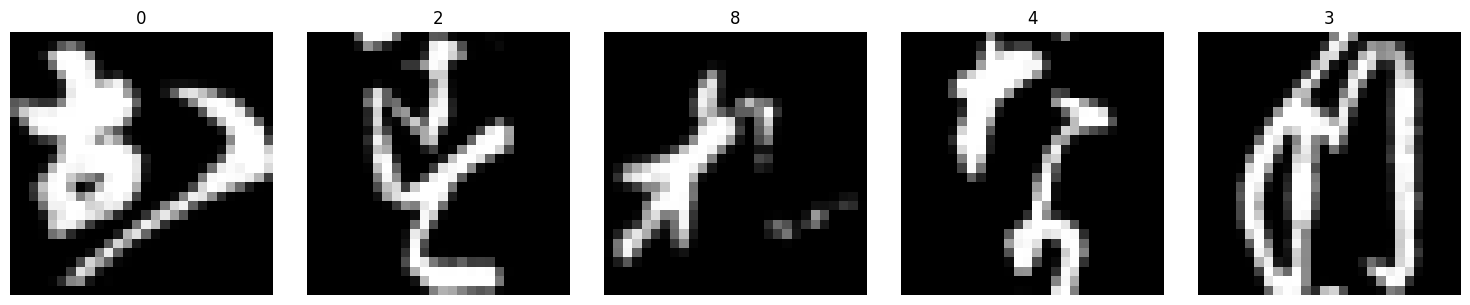

In [29]:
# plot some random images from x_train_aug
# Select 5 random indices
random_indices = np.random.choice(x_train_aug.shape[0], 5, replace=False)

# Create a figure with subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Plot each random image
for i, idx in enumerate(random_indices):
    img = x_train_aug[idx].squeeze()  # Remove single-dimensional entries
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"{y_train_aug[idx]}")

plt.tight_layout()
plt.show()




In [5]:
hyperparameters = {
    'num_layers': 3,
    'filters': [32, 64, 64],
    'kernel_sizes': [(3, 3), (3, 3), (3, 3)],
    'activations': ['relu', 'relu', 'relu'],
    'dense_units': 64,
    'dense_activation': 'relu',
    'pooling': 'avg',
    'batch_normalization': True
}

In [31]:
# Define VAE parameters
latent_dim = 2
input_shape = (28, 28, 1)

# Encoder
# Input layer
inputs = Input(shape=input_shape, name='encoder_input')
# First convolutional layer 
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
# Second convolutional layer
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)  
# Flatten layer
x = Flatten()(x)
# Dense layer
x = Dense(16, activation='relu')(x)
# Dense layer for z_mean
z_mean = Dense(latent_dim, name='z_mean')(x)
# Dense layer for z_log_var
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [32]:
# Reparameterization trick
def sampling(args):
    # Extract z_mean and z_log_var from args
    z_mean, z_log_var = args    
    # Get the batch size and dimensions
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # Generate random normal samples
    epsilon = K.random_normal(shape=(batch, dim))
    # Return the sampled z
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [33]:
# Apply the sampling function to z_mean and z_log_var
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [34]:
# Classification output
label_output = Dense(10, activation='softmax', name='label_output')(x)

Epoch 1/10
422/422 [==============================] - 5s 9ms/step - loss: 308.3031 - val_loss: 285.5771
Epoch 2/10
422/422 [==============================] - 4s 9ms/step - loss: 280.2912 - val_loss: 278.7205
Epoch 3/10
422/422 [==============================] - 4s 9ms/step - loss: 276.0619 - val_loss: 276.5463
Epoch 4/10
422/422 [==============================] - 4s 9ms/step - loss: 274.3221 - val_loss: 275.6158
Epoch 5/10
422/422 [==============================] - 4s 9ms/step - loss: 273.1137 - val_loss: 274.1030
Epoch 6/10
422/422 [==============================] - 4s 9ms/step - loss: 272.4483 - val_loss: 274.2292
Epoch 7/10
422/422 [==============================] - 4s 9ms/step - loss: 271.6632 - val_loss: 273.3286
Epoch 8/10
422/422 [==============================] - 4s 9ms/step - loss: 271.1301 - val_loss: 272.9931
Epoch 9/10
422/422 [==============================] - 4s 9ms/step - loss: 270.7764 - val_loss: 273.7676
Epoch 10/10
422/422 [==============================] - 4s 9ms/st

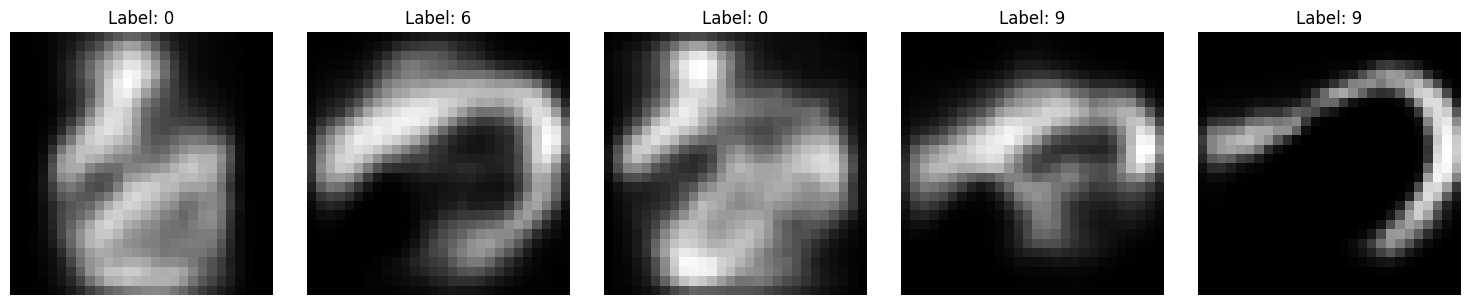

In [30]:

# Decoder   
# Input layer for latent space
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# Dense layer
x = Dense(7 * 7 * 64, activation='relu')(latent_inputs) 
# Reshape layer
x = Reshape((7, 7, 64))(x)
# First convolutional transpose layer
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
# Second convolutional transpose layer
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
# Output layer
outputs = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

# Define VAE model
# Create encoder model
encoder = Model(inputs, [z_mean, z_log_var, z, label_output], name='encoder')
encoder.summary()
# Create decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# Create VAE model
outputs = decoder(encoder(inputs)[2])
label_output = encoder(inputs)[3]
# Add the decoder output to the encoder output
vae = Model(inputs, [outputs, label_output], name='vae')

# VAE loss
reconstruction_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=[1, 2, 3])
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile and train VAE
vae.compile(optimizer='adam')
vae.fit(x_train_aug, epochs=10, batch_size=128, validation_data=(x_val, None))

# Generate a large amount of VAE images and labels
num_samples = 20  # Number of samples to generate
generated_images = []
generated_labels = []

for _ in range(num_samples):
    print('here')
    # Generate a random point in the latent space
    z_sample = np.random.normal(size=(1, latent_dim))
    
    # Decode the point to generate an image
    x_decoded = decoder.predict(z_sample)
    
    # Reshape the image
    generated_image = x_decoded[0].reshape(digit_size, digit_size, 1)
    
    # Use the encoder to get the label (classification) for the generated image
    _, _, z_encoded = encoder.predict(np.expand_dims(generated_image, axis=0))
    
    # Use the encoder output to determine the label
    # Here we're using the first dimension of the latent space as a simple heuristic
    # You might want to use a more sophisticated method depending on your specific VAE
    label = int(z_encoded[0][0] * 10)  # Scale to 0-9 range and convert to int
    # Ensure the label is within the valid range [0, 9]
    label = max(0, min(9, label))
    
    # Print for debugging
    if label < 0 or label > 9:
        print(f"Warning: Invalid label {label} generated. Clamped to {max(0, min(9, label))}.")
    generated_images.append(generated_image)
    generated_labels.append(label)

# Convert lists to numpy arrays
generated_images = np.array(generated_images)
generated_labels = np.array(generated_labels)

# Save the generated dataset
np.save('generated_images.npy', generated_images)
np.save('generated_labels.npy', generated_labels)

print(f"Generated and saved {num_samples} images and labels.")

# Visualize a few examples
n_examples = 5
fig, axes = plt.subplots(1, n_examples, figsize=(15, 3))
for i in range(n_examples):
    axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {generated_labels[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'train_images.npy'